# 【第一回目　課題１】フレームワークを使わない深層学習 (1): 全結合編

第1回目の課題１では，フレームワークを使わないで，pythonのnumpyのみを用いて簡単なネットワークの順伝搬，逆伝搬，学習を行ってみましょう．

まずは，全結合層＋ReLU＋2乗誤差関数 のネットワークを考えてみます．


全結合層を使って任意の関数の近似を行います．

In [1]:
%matplotlib inline
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

全結合層クラスFc を作ってみます．
Fc(入力要素数，出力要素数) とします．

なお，numpyでは，１次元でベクトルを表現すると横ベクトル扱いになってしまうので，
わかりやすくするために，ｎ次元ベクトルを(n,1)の２次元配列で表現することとして，
縦ベクトルで表現とします．

なお，Fcに活性化関数のReLUもまとめて入れてしまいます．
さらに，update, updatem の勾配法によるパラメータの更新の
メソッドも定義します．


In [2]:
class Fc:
    def __init__(self, n_in, n_out, relu=True, sigmoid=False, seed=0):
        self.n_in = n_in
        self.n_out = n_out
        self.relu = relu
        self.sigmoid = sigmoid
        # w,b は全結合層の学習パラメータ．
        # ReLuも全結合の中に含めてあります．
        # ReLU=Trueのときは，Heの初期値．Falseのときは，Xavierの初期値とします．．
        # xは直前のforward計算時の入力値．BPの計算時に必要．
        np.random.seed(seed) # 同じ初期値を再現できるように seed を指定します．
        if relu:
            self.w = np.random.normal(0, math.sqrt(2.0/n_in), (n_out, n_in)) # Heの初期値
            self.relu0 = None # ReLUの順伝搬時に０以下で値が伝搬されない要素のインデックスを記録．BP時に利用．
        else:
            self.w = np.random.normal(0, math.sqrt(1.0/n_in), (n_out, n_in)) # Xavierの初期値   
        self.b = np.zeros((n_out,1))
        self.x = np.zeros((n_in,1))
        #　誤差逆伝搬(Back-Propagation時の勾配を記録する変数)
        self.dEdx = np.zeros((n_in,1)) # dE/dx を表す　BPの時に直前レイヤに伝わる勾配でδと表現されます．
        self.dEdw = np.zeros((n_out,n_in)) # dE/dw を表す
        self.dEdb = np.zeros((n_out,1)) # dE/db を表す
        self.count = 0
        # 以下，MomentamSDGのための設定
        self.mdw = np.zeros((n_out,n_in))
        self.mdb = np.zeros((n_out,1))

    # forward は __call__ を使って定義する．単純な 行列＊ベクトル＋ベクトル　の計算．
    def __call__(self,x): 
        self.x = x
        self.y = np.dot(self.w, x) + self.b
        # ReLUは，値が０以下の要素は，０とする．０とした要素のインデックスは relu0に記録し，BP時に勾配を伝搬させない．
        if self.relu:
            self.relu0 = self.y <= 0
            self.y[self.relu0] = 0
            return self.y
        elif self.sigmoid:
            return 1/(1 + np.exp(-self.y))
        elif self.relu == False and self.sigmoid == False:
            return self.y
        elif self.relu and self.sigmoid:
            raise ValueError("Cannot be set multiple activation functions simultaneously")

    # backward は，dE/dy を受け取って，dE/dx を出力．内部では，dE/dw, dE/db を更新
    def backward(self, dEdy):
          # 順伝搬時に値が０以下だった要素は勾配を０として，勾配伝搬しない．
        if self.relu:
            dEdy[self.relu0] = 0
        elif self.sigmoid:
            dEdy = dEdy * self.y * (1 - self.y)
        dydx = np.transpose(self.w)  # dWx/dx= np.transpose(W) であることより．
        dydw = np.transpose(self.x)  # dWx/dW= np.transpose(x) 
          # dydb = np.ones((self.n_out,1))   #  db/db = np.ones((n_out,1))　１なので特に計算しない．
          # dEdw, dEdb に勾配を加算．dEdx (δ)は前層へ伝搬する勾配で，backwardの返り値とする．
        self.dEdx = np.dot(dydx, dEdy)
        self.dEdw += np.dot(dEdy, dydw)
        self.dEdb += dEdy
        self.count +=1  # 勾配の平均を取るために，足した勾配のサンプル数を記録．
        return self.dEdx

    # 勾配をクリア
    def clear_grad(self):
        self.dEdw = 0
        self.dEdb = 0
        self.count = 0

    # 勾配法で重みをアップデート．countで割って，足しこんだ勾配のサンプル数で平均を取る
    def update(self, lr=0.001):
        self.w -= (self.dEdw/self.count) * lr
        self.b -= (self.dEdb/self.count) * lr
        self.clear_grad()
    
    # 慣性項（モーメンタム項）付きの勾配法(課題1の5)
    def updatem(self, lr=0.001, mu=0.9):
        self.mdw = mu * self.mdw - (self.dEdw/self.count) * lr
        self.mdb = mu * self.mdb - (self.dEdb/self.count) * lr
        self.w += self.mdw
        self.b += self.mdb
        self.clear_grad()
    
    # adam (課題1の7)
    def update_adam(self, lr=0.001, beta1=0.9, beta2=0.99):
        self.mw = beta1 * self.m - (1-beta1) * (self.dEdw/self.count)
        self.vw = beta2 * self.v - (1-beta1) * (self.dEdw/self.count)**2
        
        self.mb = beta1 * self.m - (1-beta1) * (self.dEdb/self.count)
        self.vb = beta2 * self.v - (1-beta1) * (self.dEdb/self.count)**2
        
        mhat_w = self.mw / (1- beta1**count)
        vhat_w = self.vw / (1- beta2**count)
        
        mhat_b = self.mb / (1- beta1**count)
        vhat_b = self.vb / (1- beta2**count)
        
        self.w -= lr * mhat_w/(np.sqrt(vhat_w) + 1e-7)
        self.b -= lr * mhat_b/(np.sqrt(vhat_b) + 1e-7)
        
        self.clear_grad()
    
    # adagrad (課題1の7)
    def update_adagrad(self, lr=0.001):
        self.h += (self.dEdw/self.count)**2
        self.w -= lr * (self.dEdw/self.count)/(np.sqrt(self.h + 1e-7))
        self.b -= lr * (self.dEdb/self.count)/(np.sqrt(self.h + 1e-7))
        self.clear_grad()
    
    # rmsprop (課題1 任意発展課題の1)
    def update_rmsprop(self, decay_rate=0.99):
        h *= decay_rate
        self.h += (1 - decay_rate) * (self.dEdw/self.count)**2
        self.w -= lr * (self.dEdw/self.count)/(np.sqrt(self.h + 1e-7))
        self.b -= lr * (self.dEdb/self.count)/(np.sqrt(self.h + 1e-7))
        self.clear_grad()
        
    # adadelta (課題1 任意発展課題の1)
    def update_adadelta(self):
        self.clear_grad()

学習モデルのオブジェクトを生成します．
1x10+ReLU +10x10+ReLU + 10x1 の３層とします．

In [3]:
fc1 = Fc(1,20)
fc2 = Fc(20,20)
fc3 = Fc(20,1)

Fcクラスの定義が終わったので，次に，近似する関数の定義を行って，学習データ(training data)，検証データ(validation data)を生成します．

In [4]:
def f(x):
    return 0.5*(x-2)**2-5

def generate_data(f):
    X_train = np.arange(-10,10,0.01,dtype=np.float32)
    Y_train = f(X_train)

    # X_train, Y_trainは１次元配列なので，reshapeで ２次元の(n,dim)に変換します．dim=1です．
    X_train = np.reshape(X_train,[-1,1])   # (2000,)  -> (2000,1)
    Y_train = np.reshape(Y_train,[-1,1]) 
    num_train = np.size(X_train)

    # テスト用の x も準備します．
    X_val = np.arange(-8,8,0.1,dtype=np.float32)
    Y_val = f(X_val)
    X_val = np.reshape(X_val,[-1,1])
    Y_val = np.reshape(Y_val,[-1,1])
    num_val = np.size(X_val)
    return X_train, Y_train, X_val, Y_val, num_train, num_val

いよいよ，学習ループです．
誤差(loss)のグラフ表示も行います．

In [5]:
def show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, 
              num_train, num_val, learning_rate=0.001, mu=0.9, decay_rate=0.99, beta1=0.9, beta2=0.99,
              num_epoch=150, num_batch=100, optimizer="sgd"):
    """
    f: 関数
    fc1: 全結合層の1層目
    fc2: 全結合層の2層目
    fc3: 全結合層の3層目
    X_train: 学習データの実数値
    Y_train: 関数f にX_trainを代入した際の実数値
    X_val: 検証データの実数値
    Y_val: 関数f にX_valを代入した際の実数値
    num_train(int): 学習データのデータ点の数
    num_val(int): 検証データのデータ点の数
    learning_rate(float): 学習率
    mu(float): 慣性項の係数 momentum_sgdで使用
    beta1(float): adamで利用するパラメータ
    beta2(float): adamで利用するパラメータ
    num_epoch(int): エポック数
    num_batch(int): ミニバッチ数
    optimizer(list): 勾配の最適化方法 ["sgd", "momentum_sgd", "adam", "adagrad", "rmsprop", "adadelta"]という文字列を代入することを想定
    """
    
    x0 = np.reshape(X_val,[-1])

    lr = learning_rate #学習率
    mu = mu # モメンタムsgd用
    num_epoch = num_epoch # エポック数
    num_batch = num_batch # mini-batch サイズ
    #plt.hold(False)
    losses = np.array([])
    losses_val = np.array([])
    ep = np.array([])
    # 表示エリアの設定
    fig = plt.figure()
    fig1 = fig.add_subplot(121)
    fig2 = fig.add_subplot(122)
    for epoch in range(num_epoch):
    # Stochastic Gradient Descent なので，epochごとに学習データをシャッフルします．
        shuffler = np.random.permutation(num_train)
        X_train = X_train[shuffler]
        Y_train = Y_train[shuffler]
        for n in range(0, num_train, num_batch):
            loss = 0
            for i in range(num_batch):
                # 順伝搬計算
                y = fc3(fc2(fc1(np.c_[X_train[n+i]])))
                # 誤差微分値，誤差値を計算します． 
                dEdx = y - np.c_[Y_train[n+i]]
                loss += (dEdx**2)*0.5
                # dEdx (δ)を計算して，逆伝搬します．
                dEdx = fc3.backward(dEdx)
                dEdx = fc2.backward(dEdx)
                dEdx = fc1.backward(dEdx)
            # minibatch の順伝搬，逆伝搬を行ったら，SDGで重みを更新
            if optimizer == "sgd":
                fc1.update(lr)
                fc2.update(lr)
                fc3.update(lr)
            elif optimizer == "momentum_sgd":
                fc1.updatem(lr, mu)
                fc2.updatem(lr, mu)
                fc3.updatem(lr, mu)
            elif optimizer == "adam":
                fc1.update_adam(lr, beta1, beta2)
                fc2.update_adam(lr, beta1, beta2)
                fc3.update_adam(lr, beta1, beta2)
            elif optimizer == "adagrad":
                fc1.update_adagrad(lr)
                fc2.update_adagrad(lr)
                fc3.update_adagrad(lr)
            elif optimizer == "rmsprop":
                fc1.update_rmsprop(decay_rate)
                fc2.update_rmsprop(decay_rate)
                fc3.update_rmsprop(decay_rate)
            elif optimizer == "adadelta":
                fc1.update_adadelta()
                fc2.update_adadelta()
                fc3.update_adadelta()
            # 各epochの最初にグラフ表示を行います．
            if n == 0:
                losses = np.append(losses,loss/num_batch)
                ep = np.append(ep,epoch)
                # 検証用データの評価
                loss_val = 0
                Y_pred = np.array([])
                for i in range(num_val):
                    # 順伝搬計算
                    y = fc3(fc2(fc1(np.c_[X_val[i]])))
                    Y_pred = np.append(Y_pred,y)
                    # 誤差微分値，誤差値 
                    dEdx = y - np.c_[Y_val[i]]
                    loss_val += (dEdx**2) * 0.5    
                    # print y, Y_val[i], (dEdx**2)*0.5
                losses_val = np.append(losses_val, loss_val/num_val)

                display.clear_output(wait = True)
                fig1.axis([0, num_epoch, 0, 50])
                fig1.plot(ep,losses,"b",label="train loss")
                fig1.plot(ep,losses_val,"r", label="validation loss")
                fig1.legend(loc="upper right")
                
                fig2.axis([-8,8,-10,30])
                y0 = np.reshape(Y_pred,[-1])
                fig2.plot(x0,y0,"b", label="approximated function")
                fig2.plot(x0,f(x0),"r", label="original function")
                fig2.legend(loc="upper right")
                display.display(fig)
                if epoch < num_epoch-1:
                    fig1.cla()
                    fig2.cla()

    display.clear_output(wait = True)
    print("loss_val: {}".format(loss_val))

loss_val: [[1105.2294272]]


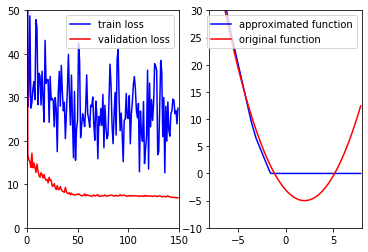

In [6]:
X_train, Y_train, X_val, Y_val, num_train, num_val = generate_data(f)
show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, num_train, num_val)

### 課題1
以下の小問の(1)-(5)を解答し，さらに(6)-(9)を1つ以上選択し回答すること．

1. 上記のコードにおける全結合層の順伝搬，逆伝搬の計算方法を説明し，上記のコードを実行せよ．
1. Reluを３層ともFalseにした場合の結果はどうなるか？ 予想して実際に試してみよ．
1. モデルパラメータ（例えば，10->30) を変化させて，結果を比較せよ．(特に最終loss値)
1. 学習率を変化させて挙動を観察せよ．
1. モーメンタムSDGに変更して，ノーマルなSDGとの違いを観察せよ．モーメンタムSDGの実装は各自完成させよ．
1. 関数 $f(x)$ を自由に書き換え，実行せよ．
1. Adam, AdaGrad のどちらか一方，もしくは両方を実装して比較せよ．
1. 一定のepoch数，もしくは一定以下の誤差値で，学習率が段階的に下がるようし，効果を検証せよ．
1. 中間層の活性化関数にReLUに加えて，Sigmoidを追加し，(1)ReLu, (2)Sigmoid (3)活性化関数なし　の３通りを比較せよ．(なお，Sigmoidのbackward は $dEdy=dEdy*self.y*(1-self.y)$ で記述できる．) 

### 【課題1: 任意発展課題】
興味のある人は，例えば，以下のような拡張を行ってみよ．

1. RMSProp,AdaDeltaも実装せよ．
1. mini-batch をループではなくて，dot の代わりに tensordot を使うようにすることすることで，まとめて一回で計算するように拡張せよ．
1. 上記のmini-batch対応を行った後，cupy ライブラリを使って，GPUに対応させよ．
1. Batch Normalization Layerを追加せよ．

### 課題1 1.上記のコードにおける全結合層の順伝搬，逆伝搬の計算方法を説明し，上記のコードを実行せよ．
コードの説明をする

### 課題1 2. Reluを３層ともFalseにした場合の結果はどうなるか？ 予想して実際に試してみよ．

Relu関数は識別関数を非線形にする作用がある．
そのため，活性化関数として，Relu関数を使わない場合(Falseにした場合)，識別関数が線形，つまり直線になる．<br>
また，学習データと検証データの誤差が縮まることはなく，差が大きくなっていく<br>
と予想．

loss_val: [[10695.93438748]]


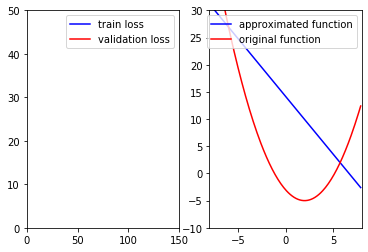

In [7]:
# Reluを3層ともすべてFalseにする
fc1_activation_false = Fc(1,20, False)
fc2_activation_false = Fc(20,20, False)
fc3_activation_false = Fc(20,1,False)
show_learning_result(f, fc1_activation_false, fc2_activation_false, fc3_activation_false, 
                     X_train, Y_train, X_val, Y_val, num_train, num_val)

### 課題1 3. モデルパラメータ（例えば，10->30) を変化させて，結果を比較せよ．(特に最終loss値)

loss_val: [[19279.07189467]]


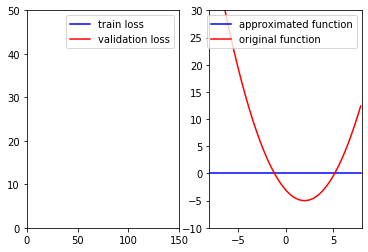

In [8]:
fc1_changed = Fc(1,20)
fc2_changed = Fc(20,100)
fc3_changed = Fc(100,1)
show_learning_result(f, fc1_changed, fc2_changed, fc3_changed, X_train, Y_train, X_val, Y_val, num_train, num_val)

loss_val: [[1146.6879902]]


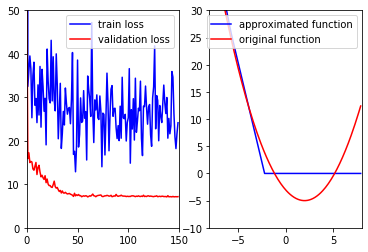

In [9]:
fc1_changed = Fc(1,20)
fc2_changed = Fc(20,5)
fc3_changed = Fc(5,1)
show_learning_result(f, fc1_changed, fc2_changed, fc3_changed, X_train, Y_train, X_val, Y_val, num_train, num_val)

### 課題1 4. 学習率を変化させて挙動を観察せよ．

loss_val: [[19279.07189467]]


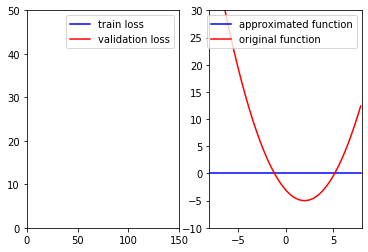

In [10]:
fc1 = Fc(1,20)
fc2 = Fc(20,20)
fc3 = Fc(20,1)
# デフォルトの値0.001よりも学習率を高くする
show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, num_train, num_val, learning_rate=0.1)

loss_val: [[1020.12138186]]


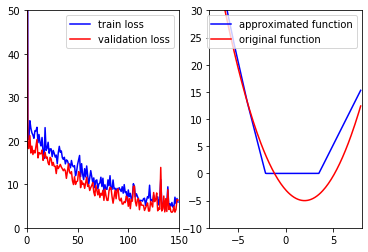

In [11]:
fc1 = Fc(1,20)
fc2 = Fc(20,20)
fc3 = Fc(20,1)
# デフォルトの値0.001よりも学習率を低くする
show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, num_train, num_val, learning_rate=0.0005)

### 課題1 5.モーメンタムSDGに変更して，ノーマルなSDGとの違いを観察せよ．モーメンタムSDGの実装は各自完成させよ．

loss_val: [[1066.24885913]]


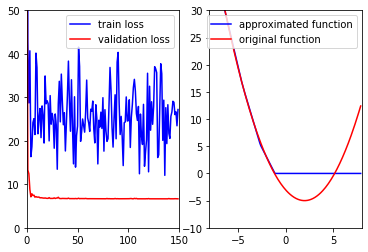

In [12]:
fc1 = Fc(1,20)
fc2 = Fc(20,20)
fc3 = Fc(20,1)
show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, num_train, num_val, optimizer="momentum_sgd")

### 課題1 6 関数  𝑓(𝑥)  を自由に書き換え，実行せよ．

loss_val: [[1539.45805194]]


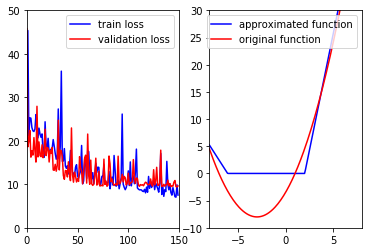

In [13]:
fc1 = Fc(1,20)
fc2 = Fc(20,20)
fc3 = Fc(20,1)

def f2(x):
    return 0.5*(x + 3)**2 - 8

X_train_f2, Y_train_f2, X_val_f2, Y_val_f2, num_train_f2, num_val_f2 = generate_data(f2)
show_learning_result(f2, fc1, fc2, fc3, X_train_f2, Y_train_f2, X_val_f2, Y_val_f2, num_train_f2, num_val_f2)

### 課題1 7. Adam, AdaGrad のどちらか一方，もしくは両方を実装して比較せよ．

In [14]:
#fc1 = Fc(1,20)
#fc2 = Fc(20,20)
#fc3 = Fc(20,1)
#show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, num_train, num_val, optimizer="adam")

In [15]:
#fc1 = Fc(1,20)
#fc2 = Fc(20,20)
#fc3 = Fc(20,1)
#show_learning_result(f, fc1, fc2, fc3, X_train, Y_train, X_val, Y_val, num_train, num_val, optimizer="adagrad")

### 課題1 9. 中間層の活性化関数にReLUに加えて，Sigmoidを追加し，(1)ReLu, (2)Sigmoid (3)活性化関数なし　の３通りを比較せよ．
### (なお，Sigmoidのbackward は  𝑑𝐸𝑑𝑦=𝑑𝐸𝑑𝑦∗𝑠𝑒𝑙𝑓.𝑦∗(1−𝑠𝑒𝑙𝑓.𝑦)  で記述できる．)

loss_val: [[nan]]


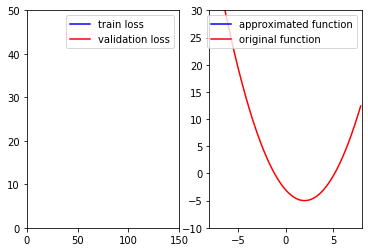

In [16]:
fc1_sigmoid = Fc(1,20,relu=False,sigmoid=True)
fc2_sigmoid = Fc(20,20,relu=False,sigmoid=True)
fc3_sigmoid = Fc(20,1,relu=False,sigmoid=True)

show_learning_result(f, fc1_sigmoid, fc2_sigmoid, fc3_sigmoid, X_train, Y_train, X_val, Y_val, num_train, num_val)

* (1) Reluの結果は 課題1の1.
* (3) 活性化関数なし の結果は 課題1の4
を参照